# Introduction
The Variational Autoencoder (VAE) introduced in the paper [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114), an extension of autoencoder neural network architecture, is used for generative modeling. It is widely being used to generate all kinds of art: text, images, audio, etc. In this notebook, we will learn how a VAE works by building and training one.

## Autoencoder vs Variational Autoencoder
An autoencoder learns to reconstruct the input image by forcing the model to learn it's dense and compact representation. This creates  a bottleneck in the information flow and forces the model to extract and learn the most important features which are necessary to reconstruct the image. Although this works, it does not gives us a continuous latent space. It just clusters the input data points in the latent space. 

### Latent space
To generate samples, the latent space needs to be continous as we should be able to sample any point in the space and be able to get a realistic sample. If the space is continuous, we also get the benefit of finding different VARIATIONS of a given sample. For example, given a sample face, we could extract a new sample having the same face but with additional features like wearing a hat or sunglasses. Different directions in the latent space have different meanings and we can follow a vector from particular points to add those meanings to the points. This process is called Latent Space Interpolation.

#### Making the latent space continuous
To convert the discrete latent space learned by an autoencoder into continuous, we add stochasticity to it. Instead of learning fixed points representing the space, we learn the probability distributions from which we can sample the points. Instead of learning one latent space vector, we learn two different vectors which represent the mean and the standard deviation of the probability distribution of the latent space respectively. This gives us smooth regions around the training data.

We still have two problems to address in this setup which we will discuss below as we proceed with building and training the network.

# Data Preparation
We will use the [Fashion-MNIST](https://arxiv.org/abs/1708.07747) dataset provided by Zalando Research for training our VAE. It is inspired by MNIST dataset and has grayscale images of fashion articles. It has the same number of data samples, classes and image size but is more complex thant the MNIST dataset. We will import the dataset from the Keras Datasets API, add the channels dimension, which in our case is 1 since the images are in grayscale, and normalize it. We will ignore the labels as we do not need them for training our VAE.

In [59]:
from keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = (x_train.reshape(x_train.shape + (1,)))/255.
x_test = (x_test.reshape(x_test.shape + (1,))) / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Building the encoder model
As discussed above, we will force the model to learn a probability distribution of the compact latent space so that it becomes continuous. We start with the image, extract features from it using convolutions, and learn two vectors that we will use to sample a point from latent space. We store the shape of the output of the last convolution layer, which we will use when we reconstruct our image back from the latent representation.

In [0]:
from keras import backend as K
from keras import Input
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Model
import numpy as np

K.clear_session()

# Hyperparameters
batch_size = 64
hidden_state_size = 8

x_input = Input(shape=(28, 28, 1), name='input_image')
x = Conv2D(32, 3, padding='same', activation='relu')(x_input)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
shape = x.shape.as_list()[1:]
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(hidden_state_size, name='z_mean')(x)
z_log_variance = Dense(hidden_state_size, name='z_log_variance')(x)

## Sampling
By adding stochasticity to the latent space, we force it to become continuous. But, we can only backpropagate our errors through deterministic nodes. To solve this, we apply a hack called the "Reparameterization Trick". Instead of making our latent space vector a stochastic node, we make it deterministic by adding a different stochastic node called "epsilon". The epsilon node simply samples values from a standard normal distribution, we multiply this epsilon with the standard deviation and add this term to the mean to get our latent space representation. The epsilon node is stochastic, but it is just a predefined distribution and we do not need to learn its parameters. This excludes it from the backpropagation and instead makes our latent space node deterministic. 

In [61]:
from keras.layers import Lambda
def sampling(args):
    z_mean, z_log_variance = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], hidden_state_size),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_variance) * epsilon
z = Lambda(sampling, name='z')([z_mean, z_log_variance])
encoder = Model(x_input, z)
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 128)  73856       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

# Building the decoder model
We will build the decoder of our VAE as a separate model with its own input and output so that we can use it later with our own latent space representations and generate samples from it. We start with the shape that we saved earlier and apply reverse convolution with the layer Conv2DTranspose and then finally convolve on it to get an output image of the same shape as of our input image.

In [62]:
from keras.layers import Reshape, Conv2DTranspose
input_z = Input(z.shape.as_list()[1:], name='input_z')
y = Dense(np.prod(shape), activation='relu')(input_z)
y = Reshape(shape)(y)
y = Conv2DTranspose(128, 3, padding='same', activation='relu', strides=(2, 2))(y)
y = Conv2D(1, 3, padding='same', activation='sigmoid', name='output_image')(y)
decoder = Model(input_z, y)
y = decoder(z)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_z (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 25088)             225792    
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       147584    
_________________________________________________________________
output_image (Conv2D)        (None, 28, 28, 1)         1153      
Total params: 374,529
Trainable params: 374,529
Non-trainable params: 0
_________________________________________________________________


# Defining the loss
By adding stochasticity to the latent space, we made the regions around the classes to be smooth. But, for latent space interpolation to work, we need to fill the gaps between these regions so that we can smoothly transition from one point in a class to another point in another class. We want to force all the regions of the different classes to coalesce into one big continuous space. We can do this by minizing the KL divergence between our latent space distribution and a standard normal distribution. This will force all of our latent space to come as close to the center and merge. Therefore, to train our VAE, we will optimize two losses: A reconstruction loss and KL-divergence loss. We use binary cross-entropy here as our reconstruction loss between the input and output image. 

In [0]:
from keras.layers import Layer
from keras.metrics import binary_crossentropy

class VariationalLayer(Layer):

    def loss(self, x, y):
        x, y = K.flatten(x), K.flatten(y)
        ce_loss = binary_crossentropy(x, y)
        kl_loss = 1 + z_log_variance - K.square(z_mean) - K.exp(z_log_variance)
        kl_loss = -0.0005*K.mean(kl_loss, axis=-1)
        return K.mean(ce_loss + kl_loss)

    def call(self, inputs):
        x, y = inputs[0], inputs[1]
        loss = self.loss(x, y)
        self.add_loss(loss, inputs=inputs)
        return loss
      
y = VariationalLayer(name='loss')([x_input, y])

# Training

In [64]:
vae = Model(x_input, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 128)  73856       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

# Latent Space Interpolation
Since we forced our latent space to be as close as possible to a standard normal deviation, we expect the space around this to be continous. We will sample equidistant points from this space and feed it to our trained decoder model and plot the generated samples. We can clearly see that the model has learned a meaningful and continuous latent space representation of our training data and we can smoothly transition from one point to another irrespective of the class. This is the most useful property of the VAE. We can give an image to our model and then traverse the latent space to get the desired realistic transformation of it!

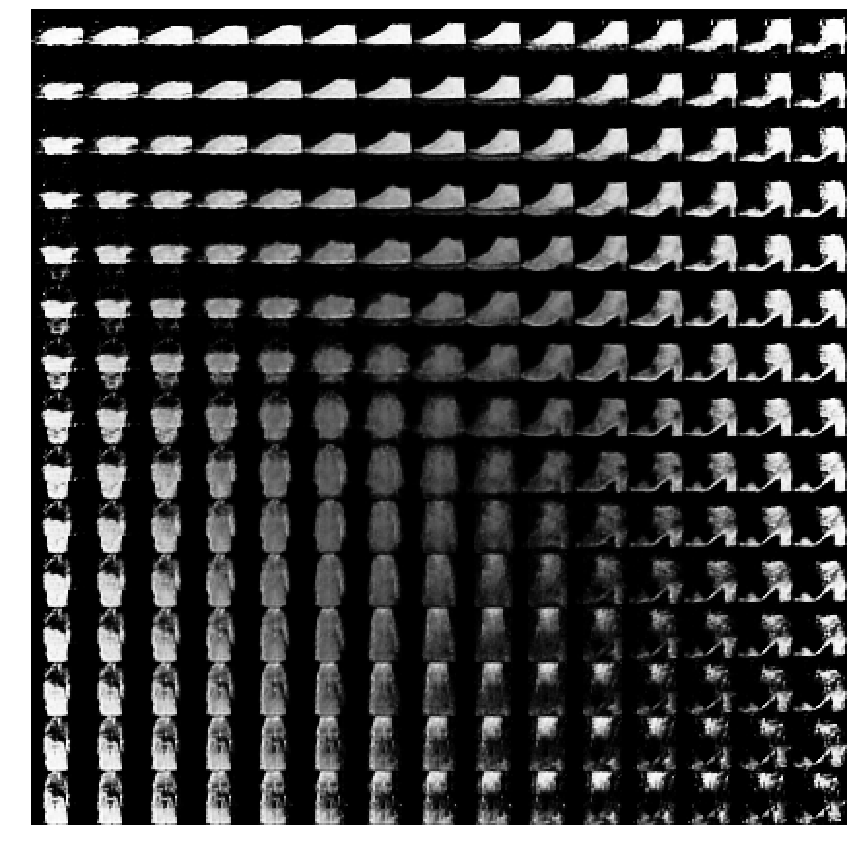

In [76]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid = norm.ppf(np.linspace(0.05, 0.95, n))

for i in range(n):
    for j in range(n):
        z_sample = np.array([grid[i]]*int(hidden_state_size/2) + 
                            [grid[j]]*int(hidden_state_size/2))
        z_sample = np.tile(z_sample, batch_size).reshape(
            batch_size, hidden_state_size)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# References

* [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
* [Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms](https://arxiv.org/abs/1708.07747)
*   https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
*   [Building autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Deep Learning Book](https://www.deeplearningbook.org/)
* [Intuitively understanding variational autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
* [Variational Autoencoders (video)](https://www.youtube.com/watch?v=9zKuYvjFFS8)



